In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("../data/raw/markowitz_dataset.csv", encoding='latin1')
data.head()

,N°DPE,secteur_activite,asset_type_cre,Emission_GES_kgCO2_m2_an,Etiquette_GES,taux_credit
0,2478T0226264E,locaux d'entreprise (bureaux),"Bâtiment à usage principale de bureau, d'admin...",6.9,B,0.02
1,2394T1781959E,locaux d'entreprise (bureaux),"Bâtiment à usage principale de bureau, d'admin...",6.1,B,0.02
2,2413T2148090B,locaux d'entreprise (bureaux),"Bâtiment à usage principale de bureau, d'admin...",9.2,B,0.02
3,2372T2176472X,U : Établissements de soins,Bâtiment à occupation continue (par exemple: h...,7.0,B,0.02
4,2482T2044916M,"W : Administrations, banques, bureaux","Bâtiment à usage principale de bureau, d'admin...",3.1,A,0.01


In [5]:
d_t = data[data['Etiquette_GES'] == 'G']
print(min(d_t['Emission_GES_kgCO2_m2_an']))
print(max(d_t['Emission_GES_kgCO2_m2_an']))

print(len(d_t[d_t['Emission_GES_kgCO2_m2_an'].between(0,200)]['Emission_GES_kgCO2_m2_an']))


6.0
255.6
6


In [6]:
data.loc[data['Etiquette_GES'] == 'G', 'Emission_GES_kgCO2_m2_an'] = data.loc[data['Etiquette_GES'] == 'G', 'Emission_GES_kgCO2_m2_an'].replace(6, 150)

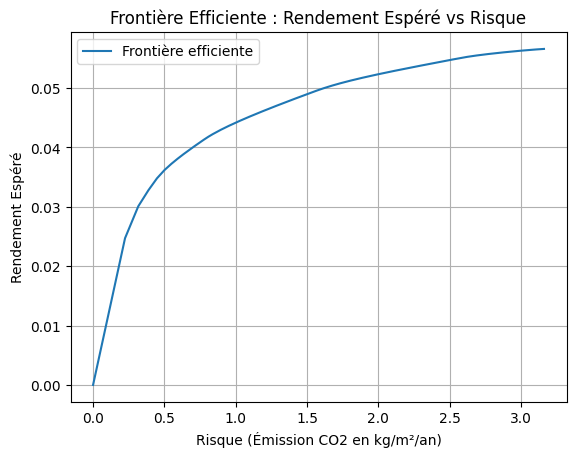

In [7]:
# Convertir en DataFrame
df = pd.DataFrame(data)

# Extraction des rendements (taux_credit) et des risques (Emission_GES_kgCO2_m2_an)
mu = df['taux_credit'].values  # Rendements espérés des actifs
risque = df['Emission_GES_kgCO2_m2_an'].values  # Risques (proxies pour la variance)

# Nombre d'actifs
n = len(mu)

# Calculer une matrice de covariance approximée en supposant que les risques sont indépendants
# Ici, nous considérons la matrice diagonale avec les "risques" comme variances
cov_matrix = np.diag(risque)

# Variables d'optimisation : poids des actifs
weights = cp.Variable(n)

# Liste pour stocker les résultats
risques = []
rendements = []

# Valeurs pour les bornes a et b
a = 0.001  # Par exemple, poids minimum
b = 0.1   # Par exemple, poids maximum

# Résoudre le problème pour différents niveaux de risque
for target_risque in np.linspace(0, 10, 200):  # Risque entre 0 et 100
    # Contrainte : somme des poids égale à 1 (portefeuille complet)
    constraints = [cp.sum(weights) == 1, weights >= 0]  # pas de vente à découvert
    # Contrainte sur le risque (variance) : limite sur le risque (variance) pour chaque niveau
    constraints.append(cp.quad_form(weights, cov_matrix) <= target_risque)
    # Contrainte sur les poids des actifs : chaque poids entre a et b
    constraints.extend([weights[i] >= a for i in range(n)])  # Poids supérieur ou égal à a
    constraints.extend([weights[i] <= b for i in range(n)])  # Poids inférieur ou égal à b

    # Objectif : maximiser le rendement du portefeuille pour ce risque
    portfolio_return = mu @ weights
    
    # Formulation du problème
    problem = cp.Problem(cp.Maximize(portfolio_return), constraints)

    # Résoudre le problème
    problem.solve()

    # Vérification si une solution a été trouvée
    if portfolio_return.value is not None:
        # Stocker les résultats
        risques.append(np.sqrt(cp.quad_form(weights, cov_matrix).value))  # Risque = racine carrée de la variance
        rendements.append(portfolio_return.value)
    else:
        # Si pas de solution, ajouter un point avec un risque et un rendement arbitraires (par exemple, NaN)
        risques.append(target_risque)
        rendements.append(0)

# Tracer la courbe Gain Espéré / Risque
plt.plot(risques, rendements, label="Frontière efficiente")
plt.xlabel('Risque (Émission CO2 en kg/m²/an)')
plt.ylabel('Rendement Espéré')
plt.title('Frontière Efficiente : Rendement Espéré vs Risque')
plt.grid(True)
plt.legend()
plt.show()

Risque cible : 5.00 - Rendement : 0.0535 - Risque réel : 2.2361
Nombre d'actifs avec poids non nul : 278
Poids moyen des actifs : 0.0036
Budget moyen par actif : 7194244.6043165475
Composition du portefeuille : {'2478T0226264E': 0.001000000035823884, '2394T1781959E': 0.0010000000358289225, '2413T2148090B': 0.0010000000358094002, '2372T2176472X': 0.001000000035823254, '2482T2044916M': 0.001000000014401799, '2436T4575820E': 0.0010000000144011116, '2433T4523995U': 0.0010000000787914784, '2495T1976448P': 0.0010000000143997377, '2554T0029713Q': 0.0010000000787295936, '2360T0389973Y': 0.0010000000358358517, '2342T3633190J': 0.0010000000784691097, '2314T0802646F': 0.0010000000357892535, '2413T2853908X': 0.0010000000144045492, '2430T2473416G': 0.0010000000787597748, '2349T1374031X': 0.0010000000143935608, '2455T1911015K': 0.0010000000358175863, '2457T3336724L': 0.0010000000787461917, '2314T2869938L': 0.0010000000143987075, '2445T3589074T': 0.001000000035827663, '2313T1017073J': 0.0010000000144

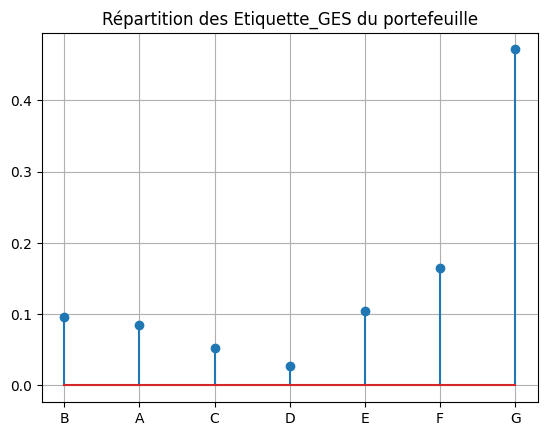

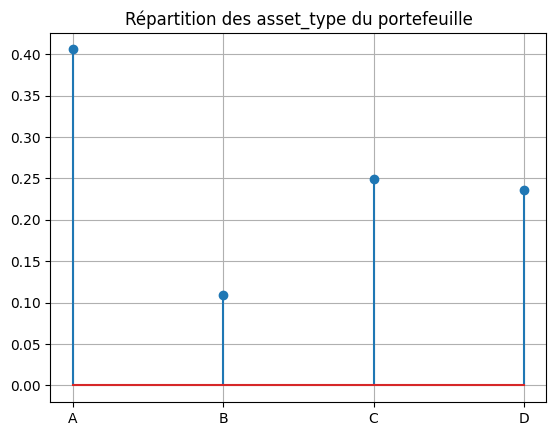

0.001000000014383627
0.09999999969650154


In [8]:
# Convertir en DataFrame
df = pd.DataFrame(data)

# Extraction des rendements (taux_credit) et des risques (Emission_GES_kgCO2_m2_an)
mu = df['taux_credit'].values  # Rendements espérés des actifs
risque = df['Emission_GES_kgCO2_m2_an'].values   # Risques (proxies pour la variance)

# Nombre d'actifs
n = len(mu)

# Calculer une matrice de covariance approximée en supposant que les risques sont indépendants
# Ici, nous considérons la matrice diagonale avec les "risques" comme variances
cov_matrix = np.diag(risque)

# Variables d'optimisation : poids des actifs
weights = cp.Variable(n)

# Valeurs pour les bornes a et b
a = 0.001  # Par exemple, poids minimum (2M minimum par actif)
b = 0.1  # Par exemple, poids maximum  (20M max)

# Résoudre le problème pour différents niveaux de risque
target_risque = 5

# Contrainte : somme des poids égale à 1 (portefeuille complet)
constraints = [cp.sum(weights) == 1, weights >= 0]  # Pas de vente à découvert
# Contrainte sur le risque (variance) : limite sur le risque (variance) pour chaque niveau
constraints.append(cp.quad_form(weights, cov_matrix) <= target_risque)
# Contrainte sur les poids des actifs : chaque poids entre a et b
constraints.extend([weights[i] >= a for i in range(n)])  # Poids supérieur ou égal à a
constraints.extend([weights[i] <= b for i in range(n)])  # Poids inférieur ou égal à b

# Objectif : maximiser le rendement du portefeuille pour ce risque
portfolio_return = mu @ weights

# Formulation du problème
problem = cp.Problem(cp.Maximize(portfolio_return), constraints)

# Résoudre le problème
problem.solve()

# Vérification si une solution a été trouvée
if portfolio_return.value is not None:
    # Récupérer les résultats : rendement et composition du portefeuille
    rendement = portfolio_return.value
    composition = weights.value
    
    # Calcul du risque réel (écart-type) du portefeuille
    real_risk = np.sqrt(cp.quad_form(weights, cov_matrix).value)
    
    # Calcul du nombre d'actifs avec poids non nul
    non_zero_weights = composition[composition > 0]
    num_assets = len(non_zero_weights)
    
    # Calcul du poids moyen des actifs
    mean_weight = np.mean(non_zero_weights) if num_assets > 0 else 0
    
    # Répartition des actifs par 'asset_type_cre'
    asset_types = df['asset_type_cre'].values
    repartition_cre = {}
    
    for i, poids in enumerate(composition):
        asset_type = asset_types[i]
        if poids > 0:  # On ne prend en compte que les actifs avec poids non nul
            if asset_type not in repartition_cre:
                repartition_cre[asset_type] = 0
            repartition_cre[asset_type] += poids
    
    
    portefeuille_results = {
        'target_risque': target_risque,
        'rendement': rendement,
        'real_risk': real_risk,
        'composition': composition,
        'num_assets': num_assets,
        'mean_weight': mean_weight,
        'repartition_cre': repartition_cre
    }
else:
    # Si pas de solution, ajouter un point avec un rendement arbitraire et une composition vide
    portefeuille_results = {
        'target_risque': target_risque,
        'rendement': np.nan,
        'real_risk': np.nan,
        'composition': [np.nan] * n,
        'num_assets': 0,
        'mean_weight': np.nan,
        'repartition_cre': {}
    }

# Calculer la répartition des actifs par Etiquette_GES
if portefeuille_results['rendement'] is not np.nan:
    composition = portefeuille_results['composition']
    # Ajouter la répartition des actifs par Etiquette_GES
    etiquettes = df['Etiquette_GES'].values
    repartition_ges = {}
    
    for i, poids in enumerate(composition):
        label = etiquettes[i]
        if label not in repartition_ges:
            repartition_ges[label] = 0
        repartition_ges[label] += poids
        
    portefeuille_results['repartition_ges'] = repartition_ges

# Affichage des résultats (rendement et composition du portefeuille)
print(f"Risque cible : {portefeuille_results['target_risque']:.2f} - Rendement : {portefeuille_results['rendement']:.4f} - Risque réel : {portefeuille_results['real_risk']:.4f}")
print(f"Nombre d'actifs avec poids non nul : {portefeuille_results['num_assets']}")
print(f"Poids moyen des actifs : {portefeuille_results['mean_weight']:.4f}")
print(f"Budget moyen par actif : {portefeuille_results['mean_weight']*2000000000}")
print(f"Composition du portefeuille : {dict(zip(df['N°DPE'], portefeuille_results['composition']))}")
print(f"Répartition par Etiquette_GES : {portefeuille_results['repartition_ges']}")
print(f"Répartition par asset_type_cre : {portefeuille_results['repartition_cre']}")

plt.stem(portefeuille_results['repartition_ges'].keys(),portefeuille_results['repartition_ges'].values())
plt.title('Répartition des Etiquette_GES du portefeuille')
plt.grid()
plt.show()

plt.stem(['A', 'B', 'C', 'D'],portefeuille_results['repartition_cre'].values())
plt.title('Répartition des asset_type du portefeuille')
plt.grid()
plt.show()

print(min(portefeuille_results['composition']))
print(max(portefeuille_results['composition']))